# Análisis Exploratorio de Datos (EDA)

Este notebook realiza un EDA riguroso para comprender distribuciones, nulos, correlaciones y patrones temporales en el problema de predicción de cancelación de reservas.

## 1. Configuración del Entorno e Importaciones

**Propósito:** Cargar todas las librerías necesarias para el análisis y establecer configuraciones globales para una visualización consistente.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats # Para análisis estadísticos si son necesarios
from statsmodels.stats.outliers_influence import variance_inflation_factor # Para VIF

# Configuraciones de visualización
%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerías y configuraciones listas.")

Librerías y configuraciones listas.


## 2. Carga y Vistazo Inicial de los Datos

**Propósito:** Cargar los conjuntos de datos de entrenamiento, prueba y la muestra de submission. Realizar una inspección inicial para entender las dimensiones, tipos de datos y ver algunas filas de ejemplo.

In [3]:
# Definición de Paths y Constantes (ajustar según estructura)
DATA_RAW_PATH = "../data/raw/" 
TRAIN_FILE = "train.csv"
TEST_FILE = "test_x.csv"
SAMPLE_SUBMISSION_FILE = "sample_submission.csv"
TARGET_COL = "Estado_Reserva"

# Carga
try:
    df_train = pd.read_csv(f"{DATA_RAW_PATH}{TRAIN_FILE}")
    df_test = pd.read_csv(f"{DATA_RAW_PATH}{TEST_FILE}")
    df_sample_submission = pd.read_csv(f"{DATA_RAW_PATH}{SAMPLE_SUBMISSION_FILE}")
    print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")
except FileNotFoundError as e:
    print(f"ERROR cargando archivos: {e}")
    raise

# Vistazo rápido
print("\nTrain Head:")
display(df_train.head(3))
print("\nTest Head:")
display(df_test.head(3))

Train shape: (31922, 20), Test shape: (4353, 19)

Train Head:


,Id,ID_Reserva,Num_Adultos,Num_Niños,Noches_Fin_Semana,Noches_Semana,Tipo_Plan_Comidas,Requiere_Estacionamiento,Tipo_Habitación_Reservada,Tiempo_Antelación,Año_Llegada,Mes_Llegada,Día_Llegada,Segmento_Mercado,Huésped_Recurrente,Num_Cancelaciones_Previas,Num_Reservas_Previas_No_Canceladas,Precio_Promedio_Por_Habitación,Num_Solicitudes_Especiales,Estado_Reserva
0,6060,INN06061,2,0,0,2,Meal Plan 1,0,NaN,57.000,2018,3,4,Online,0,0,0,80.300,NaN,No Cancelada
1,32319,INN32320,2,0,2,1,Meal Plan 1,0,Room_Type 1,282.000,2017,10,10,Offline,0,0,0,NaN,0.000,No Cancelada
2,7091,INN07092,2,0,2,4,Not Selected,0,Room_Type 1,13.000,2018,2,5,NaN,0,0,0,79.000,0.000,Cancelada



Test Head:


,Id,ID_Reserva,Num_Adultos,Num_Niños,Noches_Fin_Semana,Noches_Semana,Tipo_Plan_Comidas,Requiere_Estacionamiento,Tipo_Habitación_Reservada,Tiempo_Antelación,Año_Llegada,Mes_Llegada,Día_Llegada,Segmento_Mercado,Huésped_Recurrente,Num_Cancelaciones_Previas,Num_Reservas_Previas_No_Canceladas,Precio_Promedio_Por_Habitación,Num_Solicitudes_Especiales
0,0,INN03963,2,2,2,4,Meal Plan 1,0,Room_Type 6,13.000,2018,11,13,Online,0,0,0,NaN,0.000
1,1,INN04201,2,0,0,2,Meal Plan 1,0,Room_Type 4,0.000,2018,5,27,Online,0,0,0,NaN,NaN
2,2,INN03436,3,0,0,3,Meal Plan 1,0,Room_Type 1,14.000,2018,3,10,Offline,0,0,0,NaN,1.000


## 3. Estructura y Tipos de Datos

**Propósito:** Obtener información detallada sobre los tipos de datos de cada columna y estadísticas descriptivas generales.

In [4]:
print("--- Información Detallada del Conjunto de Entrenamiento ---")
df_train.info()

print("\n--- Estadísticas Descriptivas (Train) ---")
display(df_train.describe(include='all').T)

--- Información Detallada del Conjunto de Entrenamiento ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31922 entries, 0 to 31921
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Id                                  31922 non-null  int64  
 1   ID_Reserva                          31922 non-null  object 
 2   Num_Adultos                         31922 non-null  int64  
 3   Num_Niños                           31922 non-null  int64  
 4   Noches_Fin_Semana                   31922 non-null  int64  
 5   Noches_Semana                       31922 non-null  int64  
 6   Tipo_Plan_Comidas                   25792 non-null  object 
 7   Requiere_Estacionamiento            31922 non-null  int64  
 8   Tipo_Habitación_Reservada           28545 non-null  object 
 9   Tiempo_Antelación                   27745 non-null  float64
 10  Año_Llegada                         31922 non-

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,31922.000,NaN,NaN,NaN,18135.878,10474.958,0.000,9069.250,18125.500,27208.500,36274.000
ID_Reserva,31922,31922,INN07527,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Num_Adultos,31922.000,NaN,NaN,NaN,1.846,0.518,0.000,2.000,2.000,2.000,4.000
Num_Niños,31922.000,NaN,NaN,NaN,0.106,0.404,0.000,0.000,0.000,0.000,10.000
Noches_Fin_Semana,31922.000,NaN,NaN,NaN,0.810,0.869,0.000,0.000,1.000,2.000,6.000
Noches_Semana,31922.000,NaN,NaN,NaN,2.199,1.404,0.000,1.000,2.000,3.000,17.000
Tipo_Plan_Comidas,25792,4,Meal Plan 1,19838,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Requiere_Estacionamiento,31922.000,NaN,NaN,NaN,0.031,0.173,0.000,0.000,0.000,0.000,1.000
Tipo_Habitación_Reservada,28545,7,Room_Type 1,22140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tiempo_Antelación,27745.000,NaN,NaN,NaN,85.394,86.183,0.000,17.000,57.000,127.000,443.000


## 4. Análisis de Valores Nulos

**Propósito:** Identificar la cantidad y el porcentaje de valores nulos por columna, y visualizar patrones de nulidad para entender posibles relaciones o problemas de datos.

Valores Nulos en Train:


,Nulos,Porcentaje
Tipo_Plan_Comidas,6130,19.203
Precio_Promedio_Por_Habitación,5193,16.268
Tiempo_Antelación,4177,13.085
Segmento_Mercado,4128,12.932
Num_Solicitudes_Especiales,3927,12.302
Tipo_Habitación_Reservada,3377,10.579


Valores Nulos en Test:


,Nulos,Porcentaje
Tipo_Plan_Comidas,867,19.917
Precio_Promedio_Por_Habitación,715,16.425
Tiempo_Antelación,577,13.255
Segmento_Mercado,564,12.957
Num_Solicitudes_Especiales,544,12.497
Tipo_Habitación_Reservada,416,9.557



Visualización de Matriz de Nulos (Train):


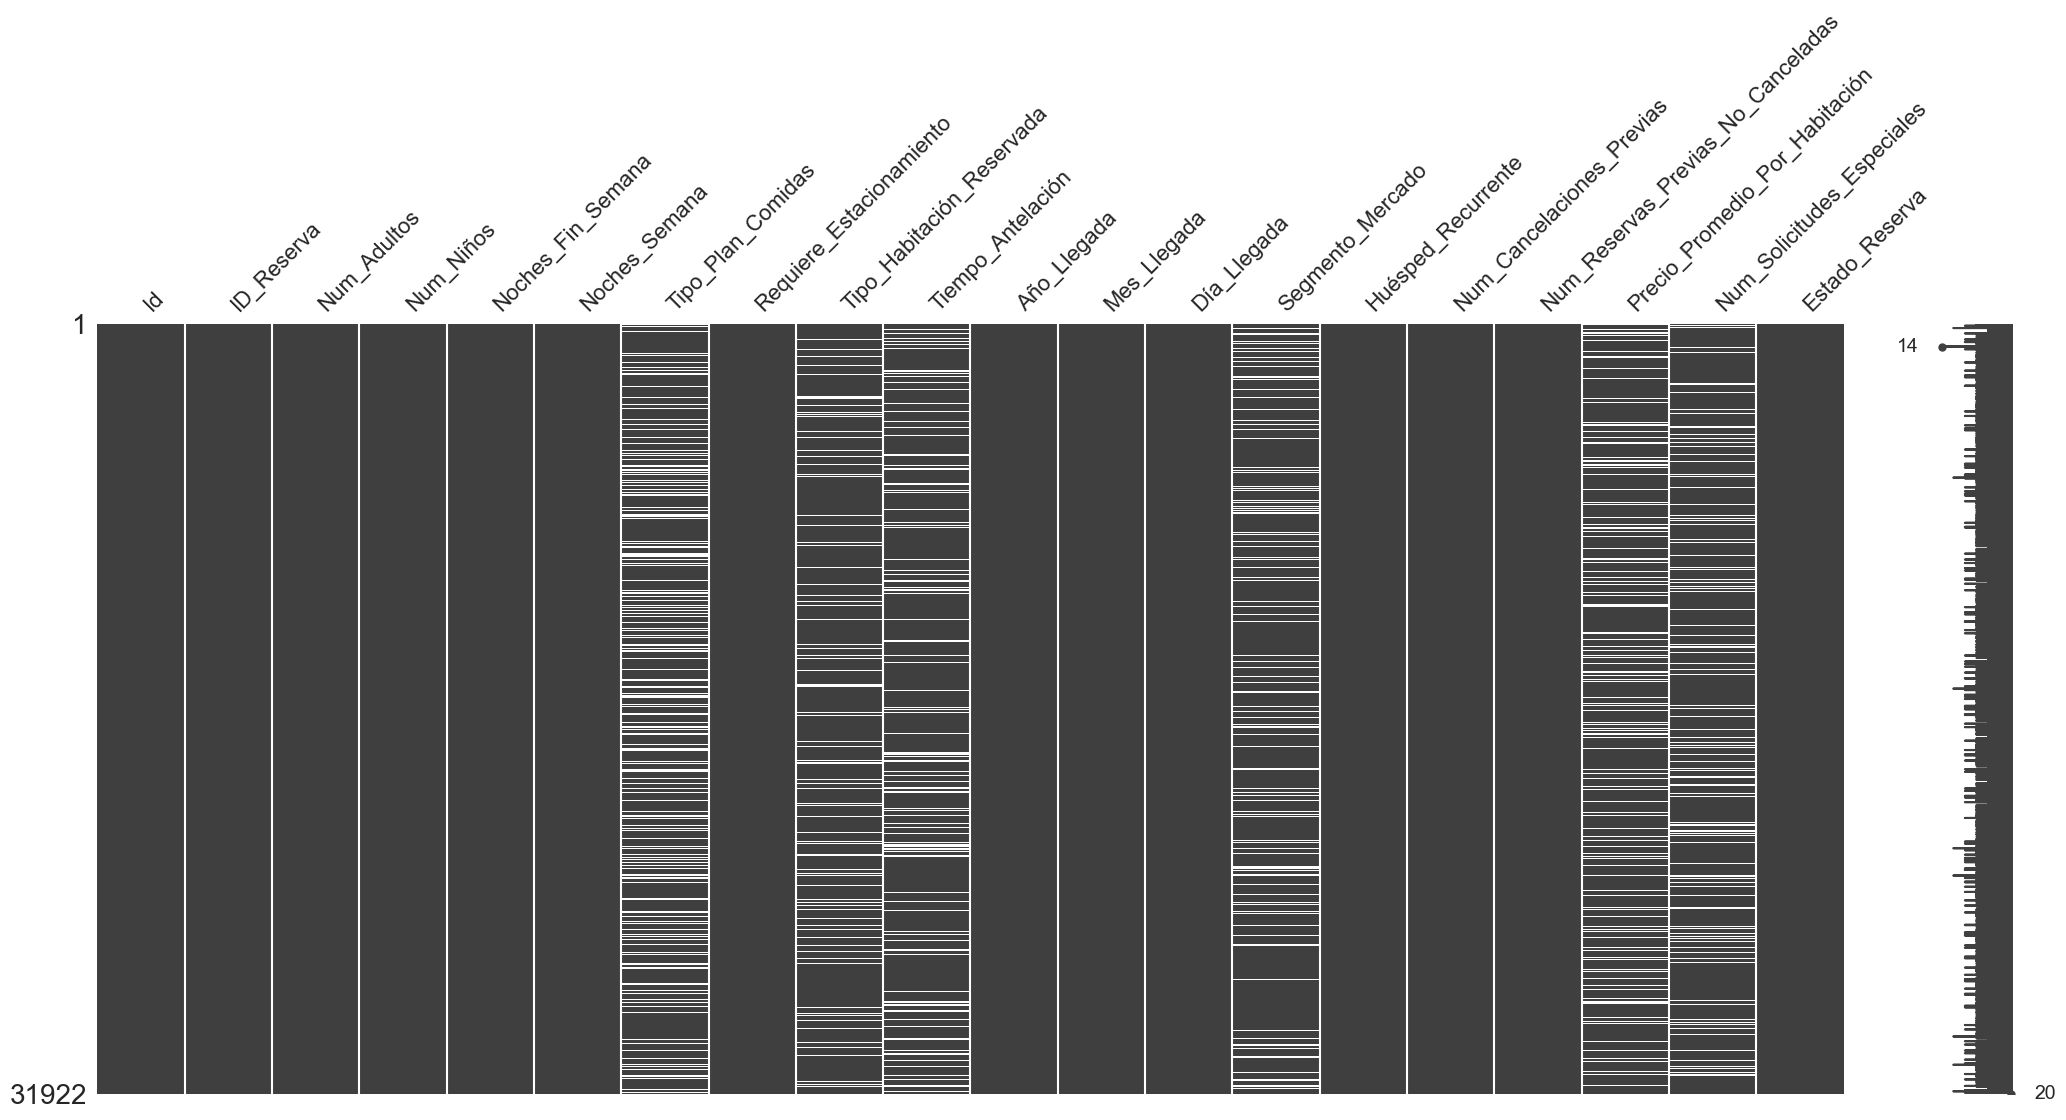

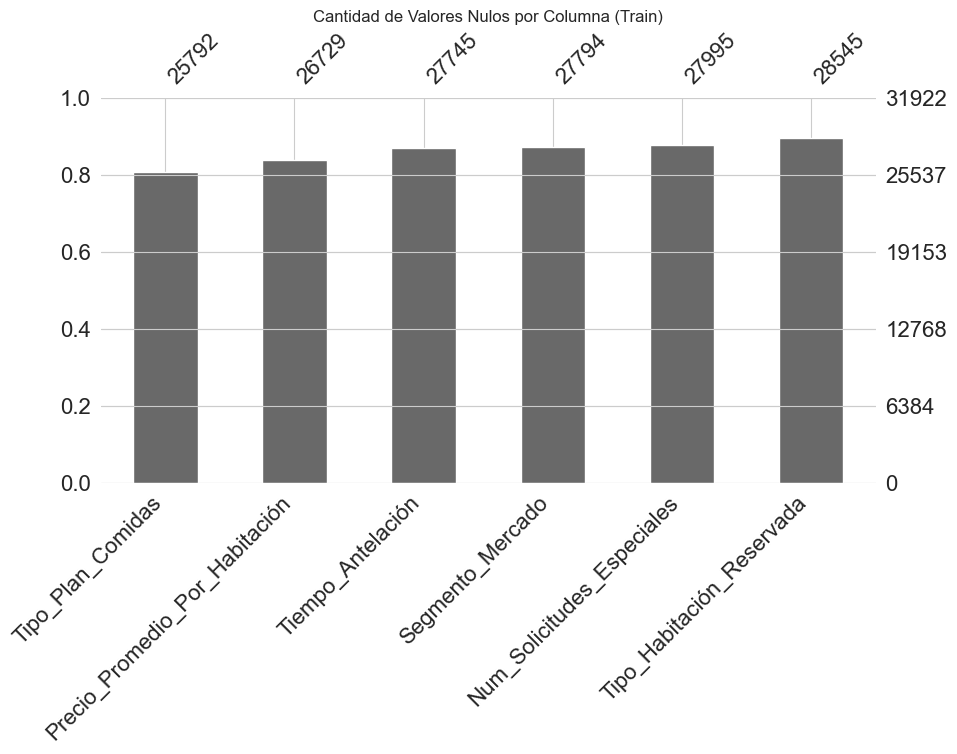

In [5]:
def summarize_missing(df, df_name="Dataset"):
    missing_summary = df.isnull().sum()
    missing_percent = (missing_summary / len(df)) * 100
    missing_table = pd.concat([missing_summary, missing_percent], axis=1, keys=['Nulos', 'Porcentaje'])
    missing_table = missing_table[missing_table['Nulos'] > 0].sort_values('Porcentaje', ascending=False)
    print(f"Valores Nulos en {df_name}:")
    if missing_table.empty:
        print("No hay valores nulos.")
    else:
        display(missing_table)
    return missing_table

missing_train = summarize_missing(df_train, "Train")
missing_test = summarize_missing(df_test, "Test")

# Visualización de patrones de nulos
print("\nVisualización de Matriz de Nulos (Train):")
msno.matrix(df_train)
plt.show()

if not missing_train.empty:
    msno.bar(df_train[missing_train.index], sort='ascending', figsize=(10,5)) # Usar index de missing_train
    plt.title("Cantidad de Valores Nulos por Columna (Train)")
    plt.show()

- Columnas afectadas: `Tipo_Plan_Comidas`, `Precio_Promedio_Por_Habitación`, `Tiempo_Antelación`, `Segmento_Mercado`, `Num_Solicitudes_Especiales`, `Tipo_Habitación_Reservada`.  
   - **Acción FE**:  
     - Numéricas → imputar con **mediana** + crear **flag binario** `is_null_*`.  
     - Categóricas → rellenar con categoría `"Missing"`, luego agrupar las seltenas en `"Other"` y target-encode con smoothing.

## 5. Análisis de la Variable Objetivo (`Estado_Reserva`)

**Propósito:** Entender la distribución de la variable que queremos predecir para identificar si hay desbalance de clases, lo cual afectará la elección de métricas y estrategias de modelado.

/var/folders/gz/gdrjz7wn4f526406r69vlxl40000gn/T/ipykernel_2767/1724000899.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=TARGET_COL, data=df_train, palette={'No Cancelada': 'skyblue', 'Cancelada': 'salmon'})


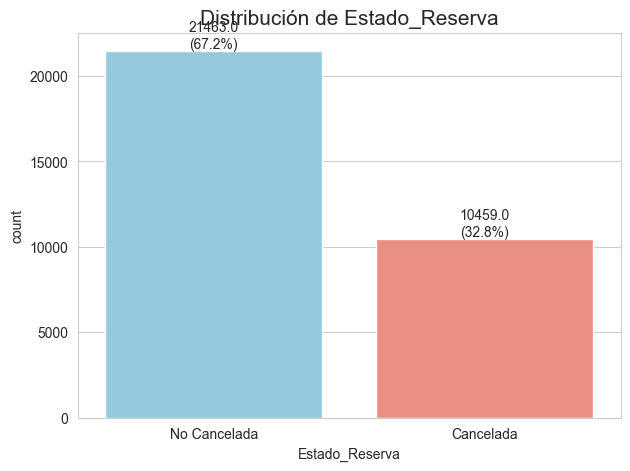

Estado_Reserva
No Cancelada   0.672
Cancelada      0.328
Name: proportion, dtype: float64


In [6]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(x=TARGET_COL, data=df_train, palette={'No Cancelada': 'skyblue', 'Cancelada': 'salmon'})
total = len(df_train[TARGET_COL])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x_coord = p.get_x() + p.get_width() / 2
    y_coord = p.get_height()
    ax.text(x_coord, y_coord, f'{p.get_height()}\n({percentage})', ha='center', va='bottom')
plt.title(f'Distribución de {TARGET_COL}', fontsize=15)
plt.show()

print(df_train[TARGET_COL].value_counts(normalize=True))

Desbalance moderado: en e- Desbalance moderado: más no canceladas que canceladas.  
   - **Acción Modelado**:  
     - Usar `class_weight='balanced'` o `scale_pos_weight`.  
     - Validación con **StratifiedKFold**.  
     - Optimizar la **Weighted F1-Score** y calibrar umbral de decisión.l modelado usaremos class_weight='balanced' y validación estratificada para mantener la proporción.

## 6. Análisis Univariado de Features

**Propósito:** Examinar la distribución de cada feature individualmente para entender su naturaleza, rango de valores, y identificar posibles outliers o sesgos.

### 6.1. Features Numéricas


Analizando 14 features numéricas: ['Num_Adultos', 'Num_Niños', 'Noches_Fin_Semana', 'Noches_Semana', 'Requiere_Estacionamiento', 'Tiempo_Antelación', 'Año_Llegada', 'Mes_Llegada', 'Día_Llegada', 'Huésped_Recurrente', 'Num_Cancelaciones_Previas', 'Num_Reservas_Previas_No_Canceladas', 'Precio_Promedio_Por_Habitación', 'Num_Solicitudes_Especiales']


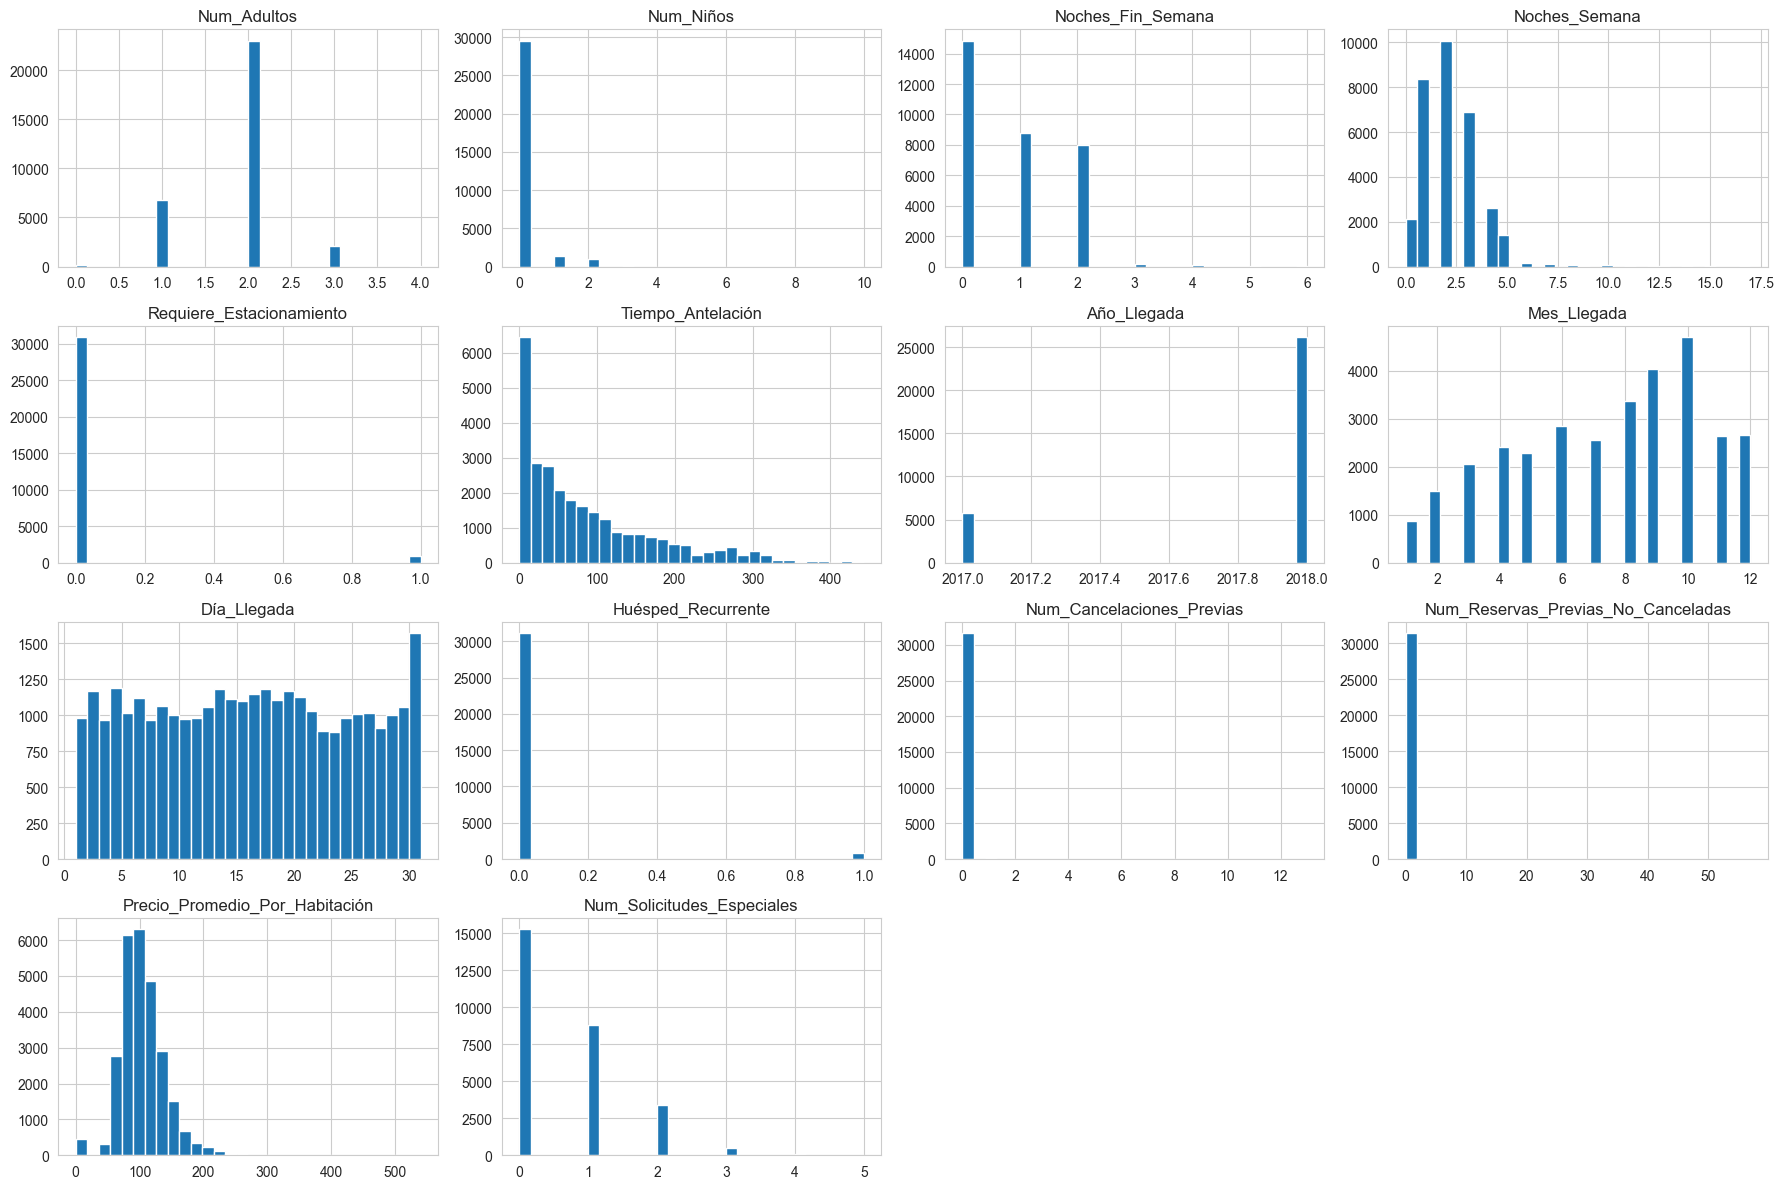

In [7]:
# Identificar columnas numéricas (excluyendo IDs si los tuvieras como int/float)
numerical_cols = df_train.select_dtypes(include=np.number).columns.tolist()
# Remover IDs si están como numéricos y target si ya estuviera mapeado (aunque aquí TARGET_COL es object)
ids_to_exclude_from_num = ['Id'] # Asumiendo 'Id' es el ID numérico
numerical_cols = [col for col in numerical_cols if col not in ids_to_exclude_from_num]

print(f"Analizando {len(numerical_cols)} features numéricas: {numerical_cols}")

df_train[numerical_cols].hist(bins=30, figsize=(18, 12), layout=(-1, 4)) # Ajustar layout según cantidad
plt.tight_layout()
plt.show()

Esto en base a los histogramas de aquí y la estadística descriptiva anterior:


- `Tiempo_Antelación`: cola larga hasta 443 días.  
- `Precio_Promedio_Por_Habitación`: media ≈100 €, outliers hasta 540 €.  
- Features de baja varianza (`Num_Adultos`, `Num_Niños`, `Huésped_Recurrente`) quedan para interacciones.  
- **Acción FE**:  
    - **Log(1+x)** o **winsorización** (percentil 1–99) en antelación y precio.  
    - **Bucketizar** antelación ([0], [1–7], [8–30], [>30]) y duración total.

### 6.2. Features Categóricas

Analizando 3 features categóricas: ['Tipo_Plan_Comidas', 'Tipo_Habitación_Reservada', 'Segmento_Mercado']

--- Tipo_Plan_Comidas ---
Valores Únicos: 4


,proportion
Tipo_Plan_Comidas,
Meal Plan 1,0.621
NaN,0.192
Not Selected,0.114
Meal Plan 2,0.073
Meal Plan 3,0.000


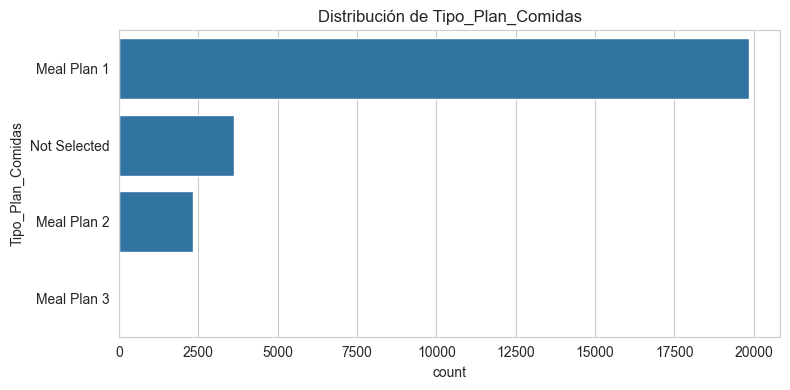


--- Tipo_Habitación_Reservada ---
Valores Únicos: 7


,proportion
Tipo_Habitación_Reservada,
Room_Type 1,0.694
Room_Type 4,0.149
NaN,0.106
Room_Type 6,0.024
Room_Type 2,0.017
Room_Type 5,0.007
Room_Type 7,0.004
Room_Type 3,0.000


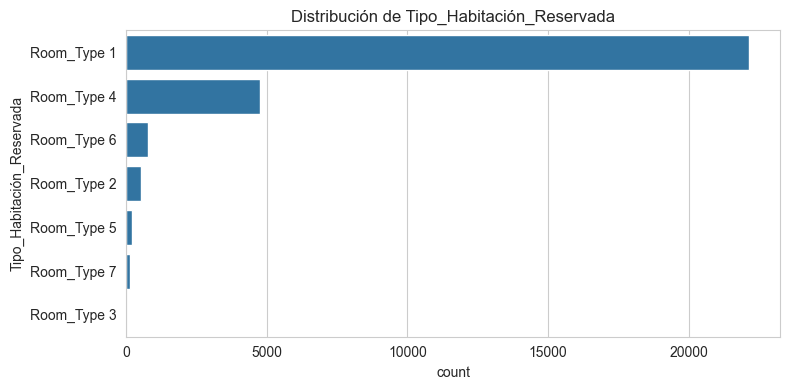


--- Segmento_Mercado ---
Valores Únicos: 5


,proportion
Segmento_Mercado,
Online,0.557
Offline,0.254
NaN,0.129
Corporate,0.047
Complementary,0.010
Aviation,0.003


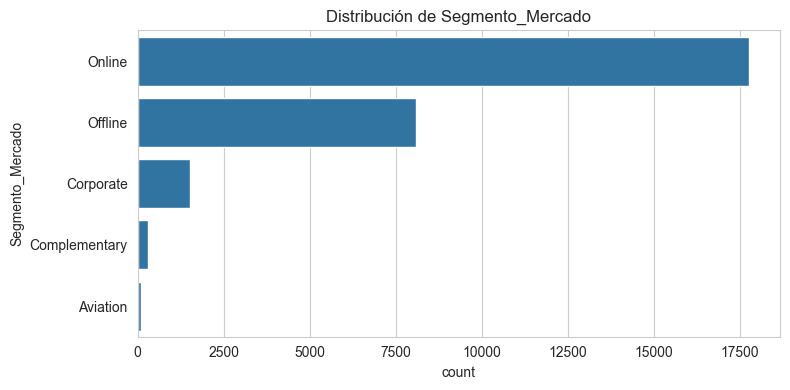

In [8]:
categorical_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in [TARGET_COL, 'ID_Reserva']] # Excluir target y ID_Reserva de texto

print(f"Analizando {len(categorical_cols)} features categóricas: {categorical_cols}")

for col in categorical_cols:
    print(f"\n--- {col} ---")
    print(f"Valores Únicos: {df_train[col].nunique()}")
    display(df_train[col].value_counts(normalize=True, dropna=False).head(10).to_frame()) # Porcentaje y nulos
    
    if df_train[col].nunique() < 20: # Solo graficar si no son demasiadas categorías
        plt.figure(figsize=(8, max(4, df_train[col].nunique()*0.3)))
        sns.countplot(y=col, data=df_train, order=df_train[col].value_counts().index[:15])
        plt.title(f"Distribución de {col}")
        plt.tight_layout()
        plt.show()

## 7. Análisis Bivariado y Multivariado

**Propósito:** Investigar la relación entre las features y la variable objetivo, así como las correlaciones entre features para detectar multicolinealidad.

### 7.1. Correlación de Features Numéricas y VIF


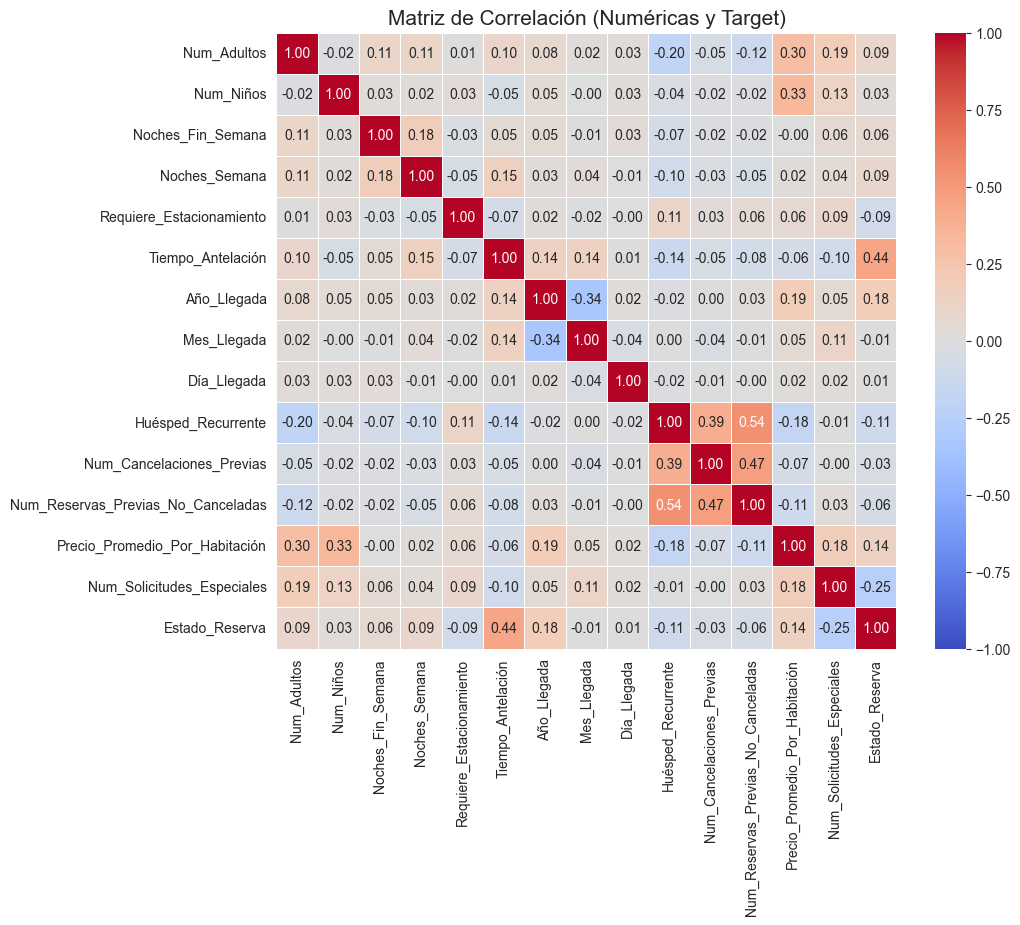


Factor de Inflación de la Varianza (VIF) para Features Numéricas:


,feature,VIF
6,Año_Llegada,29.499
0,Num_Adultos,16.394
12,Precio_Promedio_Por_Habitación,12.589
7,Mes_Llegada,7.164
8,Día_Llegada,4.222
3,Noches_Semana,3.656
5,Tiempo_Antelación,2.168
2,Noches_Fin_Semana,1.949
13,Num_Solicitudes_Especiales,1.794
11,Num_Reservas_Previas_No_Canceladas,1.702


In [12]:
# Mapear target para análisis de correlación
df_train_corr = df_train.copy()
target_map_corr = {'No Cancelada': 0, 'Cancelada': 1}
df_train_corr[TARGET_COL] = df_train_corr[TARGET_COL].map(target_map_corr)

# Incluir target en la lista de columnas numéricas para la correlación
cols_for_corr = numerical_cols + [TARGET_COL]
correlation_matrix = df_train_corr[cols_for_corr].corr()

plt.figure(figsize=(max(10, len(cols_for_corr)*0.6), max(8, len(cols_for_corr)*0.5)))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title('Matriz de Correlación (Numéricas y Target)', fontsize=15)
plt.show()

# Cálculo de VIF (Factor de Inflación de la Varianza)
# VIF solo para features predictoras, no el target. Usar datos sin nulos para VIF.
df_numerical_no_na = df_train[numerical_cols].dropna() # O imputar antes de VIF
if not df_numerical_no_na.empty and len(df_numerical_no_na.columns) > 1:
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_numerical_no_na.columns
    vif_data["VIF"] = [variance_inflation_factor(df_numerical_no_na.values, i) for i in range(len(df_numerical_no_na.columns))]
    vif_data = vif_data.sort_values(by="VIF", ascending=False)
    print("\nFactor de Inflación de la Varianza (VIF) para Features Numéricas:")
    display(vif_data)
else:
    print("\nNo se pudo calcular VIF (pocas features numéricas sin nulos o dataset vacío tras dropna).")

**Observaciones clave:**
- **`Tiempo_Antelación`** tiene la correlación más alta con la cancelación (≈ 0.44).  
  → Señal fuerte: cuanta más antelación, más probabilidad de cancelar.
- **`Precio_Promedio_Por_Habitación`** muestra correlación moderada (≈ 0.14) pero VIF alto (≈ 12.6).  
  → Multicolinealidad con `Num_Adultos`, `Num_Niños` y duración.
- **`Noches_Semana`** y **`Noches_Fin_Semana`** correlacionan entre sí y con la suma (`Duración_Total`).  
  → Redundancia: mejor agregar y usar solo `Duración_Total`.
- **`Año_Llegada`** tiene VIF muy alto (≈ 29) pero aporta poca variación real (2017 vs 2018).  
  → Descartar `Año_Llegada` y reemplazar `Mes_Llegada` por variables cíclicas.

**Próximas acciones FE:**
1. Crear `Duración_Total = Noches_Semana + Noches_Fin_Semana` y descartar las dos originales.  
2. Transformar `Tiempo_Antelación` con **log1p** y/o **binning** (e.g. [0], [1–7], [8–30], [>30]).  
3. Derivar `Precio_por_Noche = Precio / Duración_Total` y `Precio_por_Persona = Precio / (Num_Adultos+Num_Niños)`, luego descartar `Precio_Promedio_Por_Habitación`.  
4. Eliminar `Año_Llegada`, convertir `Mes_Llegada` en `sin(2π·m/12)` y `cos(2π·m/12)`.

### 7.2. Features Categóricas vs Target



--- Tipo_Plan_Comidas vs Estado_Reserva ---


,Tasa_Cancelacion,N_Observaciones
Tipo_Plan_Comidas,,
Meal Plan 2,0.455,2325
Not Selected,0.329,3625
Meal Plan 1,0.310,19838
Meal Plan 3,0.250,4


/var/folders/gz/gdrjz7wn4f526406r69vlxl40000gn/T/ipykernel_2767/630423325.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=agg_df.index, x='Tasa_Cancelacion', data=agg_df, palette="viridis")


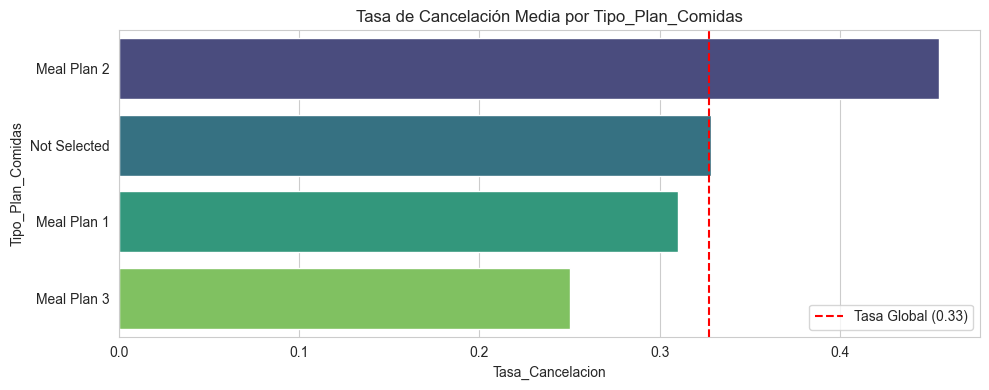


--- Tipo_Habitación_Reservada vs Estado_Reserva ---


,Tasa_Cancelacion,N_Observaciones
Tipo_Habitación_Reservada,,
Room_Type 6,0.416,772
Room_Type 4,0.342,4758
Room_Type 1,0.322,22140
Room_Type 2,0.309,534
Room_Type 5,0.260,208
Room_Type 3,0.250,4
Room_Type 7,0.225,129


/var/folders/gz/gdrjz7wn4f526406r69vlxl40000gn/T/ipykernel_2767/630423325.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=agg_df.index, x='Tasa_Cancelacion', data=agg_df, palette="viridis")


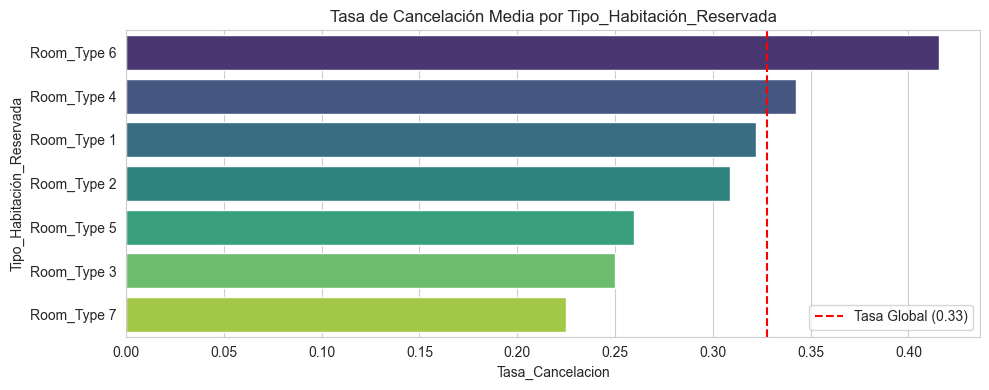


--- Segmento_Mercado vs Estado_Reserva ---


,Tasa_Cancelacion,N_Observaciones
Segmento_Mercado,,
Online,0.364,17788
Aviation,0.310,87
Offline,0.301,8095
Corporate,0.106,1516
Complementary,0.000,308


/var/folders/gz/gdrjz7wn4f526406r69vlxl40000gn/T/ipykernel_2767/630423325.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=agg_df.index, x='Tasa_Cancelacion', data=agg_df, palette="viridis")


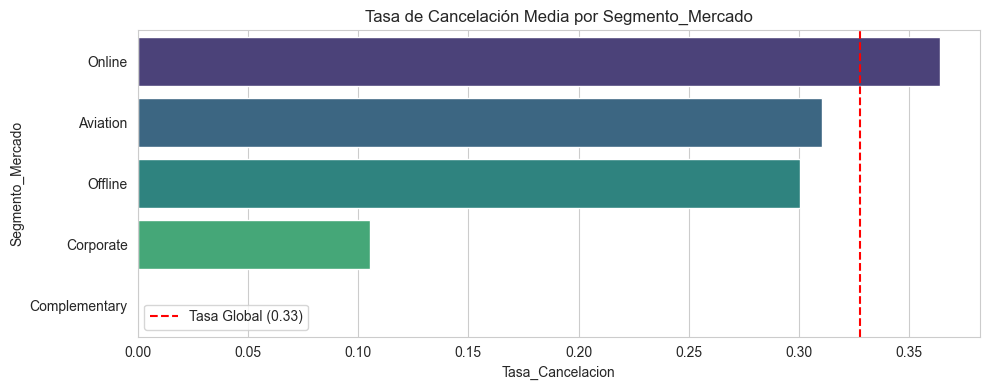

In [10]:
# Usamos df_train_corr que ya tiene el target mapeado
for col in categorical_cols:
    # Agrupar por categoría y calcular la media del target (tasa de cancelación)
    agg_df = df_train_corr.groupby(col)[TARGET_COL].agg(['mean', 'count']) \
                         .rename(columns={'mean': 'Tasa_Cancelacion', 'count': 'N_Observaciones'}) \
                         .sort_values(by='Tasa_Cancelacion', ascending=False)
    
    print(f"\n--- {col} vs {TARGET_COL} ---")
    display(agg_df)
    
    if df_train_corr[col].nunique() < 20 and not agg_df.empty: # Graficar si no son demasiadas
        plt.figure(figsize=(10, max(4, len(agg_df)*0.3)))
        sns.barplot(y=agg_df.index, x='Tasa_Cancelacion', data=agg_df, palette="viridis")
        plt.axvline(df_train_corr[TARGET_COL].mean(), ls='--', color='red', label=f'Tasa Global ({df_train_corr[TARGET_COL].mean():.2f})')
        plt.title(f"Tasa de Cancelación Media por {col}")
        plt.legend()
        plt.tight_layout()
        plt.show()

**Observaciones clave:**
- **Tipo de Plan de Comidas**:  
  - “Meal Plan 2” cancela ~45 % (vs 33 % global).  
  - “Not Selected” y nulos también están por encima de la media.  
- **Tipo de Habitación**:  
  - “Room_Type 6” (~42 %) y “Room_Type 4” (~34 %) muy por encima de la media.  
  - Muchas categorías con muy pocas observaciones (< 1 %).  
- **Segmento de Mercado**:  
  - “Online” (~36 %) y “Aviation” (~31 %) riesgo alto.  
  - “Corporate” y “Complementary” casi no cancelan (< 10 %).

**Próximas acciones FE:**
1. Agrupar categorías raras en **“Other”**.  
2. Crear buckets **High-risk** vs **Low-risk** para plan, habitación y mercado.  
3. Aplicar **target-encoding OOF** (suavizado) para capturar la tasa real sin filtrar información.

## 8. Análisis Temporal (Básico)

**Propósito:** Explorar si existen patrones o tendencias en las reservas a lo largo del tiempo (meses, años) que puedan influir en las cancelaciones.

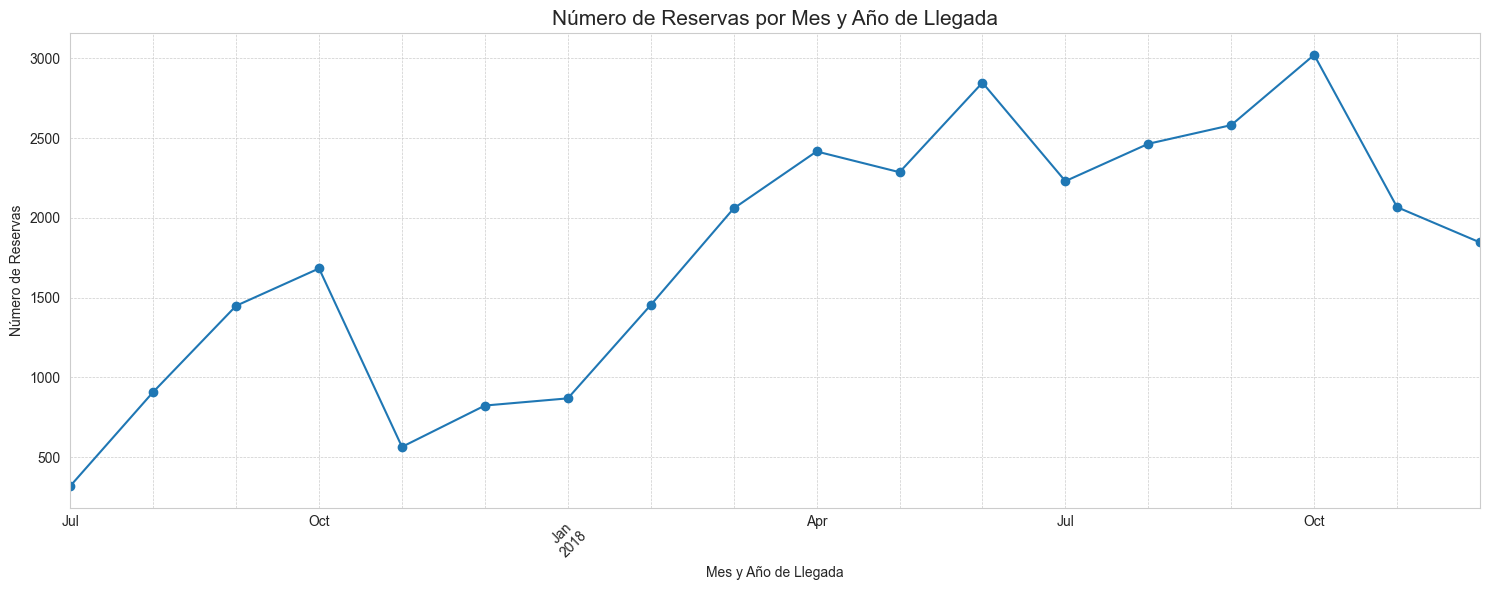

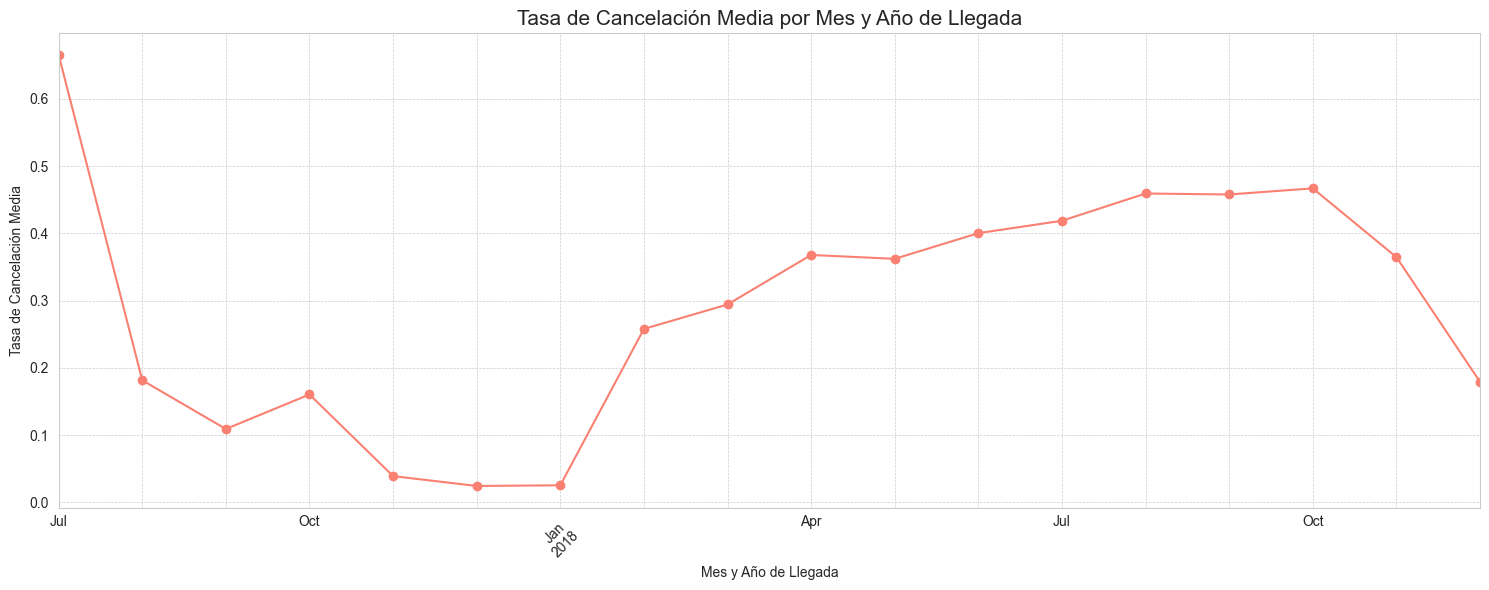

In [11]:
# Crear columna de fecha (si no se hizo antes)
try:
    df_train_eda_temp = df_train.copy() # Usar una copia para no modificar df_train globalmente aquí
    df_train_eda_temp['Fecha_Llegada'] = pd.to_datetime(
        df_train_eda_temp['Año_Llegada'].astype(str) + '-' +
        df_train_eda_temp['Mes_Llegada'].astype(str) + '-' +
        df_train_eda_temp['Día_Llegada'].astype(str),
        errors='coerce' # Manejar errores si alguna fecha es inválida
    )
    df_train_eda_temp.dropna(subset=['Fecha_Llegada'], inplace=True) # Dropear filas donde la fecha no se pudo parsear

    df_train_eda_temp['Mes_Anio_Llegada'] = df_train_eda_temp['Fecha_Llegada'].dt.to_period('M')
    
    reservas_por_mes_anio = df_train_eda_temp.groupby('Mes_Anio_Llegada').size()
    
    if not reservas_por_mes_anio.empty:
        plt.figure(figsize=(15, 6))
        reservas_por_mes_anio.plot(kind='line', marker='o')
        plt.title('Número de Reservas por Mes y Año de Llegada', fontsize=15)
        plt.ylabel('Número de Reservas')
        plt.xlabel('Mes y Año de Llegada')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # También la tasa de cancelación por mes/año (requiere target mapeado)
        df_train_eda_temp[TARGET_COL] = df_train_eda_temp[TARGET_COL].map(target_map_corr) # Re-mapear si es necesario
        cancel_rate_mes_anio = df_train_eda_temp.groupby('Mes_Anio_Llegada')[TARGET_COL].mean()
        if not cancel_rate_mes_anio.empty:
            plt.figure(figsize=(15, 6))
            cancel_rate_mes_anio.plot(kind='line', marker='o', color='salmon')
            plt.title('Tasa de Cancelación Media por Mes y Año de Llegada', fontsize=15)
            plt.ylabel('Tasa de Cancelación Media')
            plt.xlabel('Mes y Año de Llegada')
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
    else:
        print("No se pudieron generar datos temporales para graficar.")
        
except Exception as e:
    print(f"Error en análisis temporal: {e}")

**Observaciones clave:**
- **Volumen de reservas** crece de julio 2017 (~300) hasta octubre 2018 (~3000).  
  → Patrón estacional: baja en verano, pico en invierno.  
- **Tasa de cancelación** muy alta en julio 2017 (~65 %), mínima en enero 2018 (~2 %), vuelve a subir gradualmente hasta octubre 2018 (~47 %).  

**Próximas acciones FE / Validación:**
1. Codificar `Mes_Anio_Llegada` con variables cíclicas **sin/cos** para capturar periodicidad.  
2. Crear un feature categórico **“Season_Bucket”** (e.g. High-risk Winter vs Low-risk Summer) basado en la tasa promedio.  
3. Reservar un **hold-out temporal** (últimas X semanas) para comprobar que estas transformaciones generalizan fuera de muestra.

## 9. Conclusiones del EDA y Próximos Pasos

**Propósito:** Resumir los hallazgos clave del análisis exploratorio y definir las acciones concretas para las fases de preprocesamiento, ingeniería de características y modelado.

### Hallazgos Clave

1. **Valores nulos consistentes (10–20 %)**  
   - Afectan a plan de comidas, precio, antelación, segmento, solicitudes y tipo habitación.  
   - Patrón muy similar en train y test → mismo pipeline de imputación.

2. **Desbalance moderado del target (67 % vs 33 %)**  
   - Necesario usar validación estratificada y ajustar pesos de clase o remuestreo.

3. **Señal fuerte en numéricas**  
   - `Tiempo_Antelación` (corr ≈ 0.44) y `Precio` (corr ≈ 0.14) con colas largas y outliers.  
   - Duración en noches redundante: sumar y bucketizar para capturar no linealidad.

4. **Multicolinealidad detectada**  
   - VIF muy alto en `Año_Llegada` (≈ 29) y `Precio` (≈ 12.6).  
   - Necesario descartar/transformar variables redundantes (Año, noches separadas, precio puro).

5. **Categóricas con distinto riesgo**  
   - “Meal Plan 2”, “Room_Type 6/4” y segmento “Online/Aviation” tienen tasas de cancelación > 40 %.  
   - Otras categorías y nulos requieren bucket “Other” o flag “High-risk”.

6. **Estacionalidad marcada**  
   - Volumen y tasa de cancelación varían drásticamente por mes/año (pico en verano, valle en invierno).  
   - Transformar mes como variable cíclica y crear “Season_Bucket” de riesgo.

### Próximos Pasos

1. **Preprocesamiento**  
   - Imputar numéricos con mediana + flags de nulo.  
   - Rellenar categóricas nulas con “Missing” y agrupar rarezas en “Other”.  
   - Winsorizar outliers (percentil 1–99) o aplicar `log1p`.

2. **Feature Engineering**  
   - Numéricas:  
     - `log1p(Tiempo_Antelación)`, bins de antelación.  
     - `Duración_Total`, `Precio_por_Noche`, `Precio_por_Persona`.  
   - Categóricas:  
     - Buckets High-risk vs Low-risk para plan, habitación, mercado.  
     - Target-encoding OOF con smoothing + flags de high-risk.  
   - Temporales:  
     - `sin/cos(Mes_Llegada)`, `Season_Bucket` (verano, invierno…).  
     - Flag “SameDayBooking”.

3. **Validación**  
   - Implementar **StratifiedKFold** encapsulando todo el pipeline (imputación, FE, encoding).  
   - Reservar un **hold‐out temporal** (últimas semanas) para validación final y detectar drift.

4. **Modelado**  
   - Base LightGBM con parámetros iniciales y `categorical_feature`.  
   - Optimizar hiperparámetros con Optuna enfocándose en Weighted F1.  
   - Ajustar umbral de decisión sobre OOF para maximizar F1.

5. **Ensamble y Deploy**  
   - Combinar LightGBM, XGBoost, CatBoost y ExtraTrees via blending/stacking.  
   - Calibrar probabilidades (Platt/Isotonic).  
   - Estructurar scripts CLI para reproducibilidad total y generar submission.